In [1]:
import os
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from helpers import plots

import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


#### Initialize model

In [2]:
batch_size = 64
epochs = 15
IMG_HEIGHT = 240
IMG_WIDTH = 240

model_path = '../models/brats19_hgglgg_4.h5'


In [3]:
model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_a'),
        MaxPooling2D(name='max_a'),
        BatchNormalization(name='batch_norm'),
        Dropout(0.2,name='drop_a'),
        Conv2D(32, 3, padding='same', activation='relu', name='conv_b'),
        MaxPooling2D(name='max_b'),
        Conv2D(64, 3, padding='same', activation='relu', name='conv_c'),
        MaxPooling2D(name='max_c'),
        Conv2D(128, 3, padding='same', activation='relu', name='conv_d'),
        MaxPooling2D(name='max_d'),
        Dropout(0.2, name='drop_c'),
        Flatten(name='flat_a'),
        Dense(64, activation='relu', name='dense_a'),
        Dense(2, activation="softmax", name='dense_b')
    ])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Load from directory

In [4]:
train_dir = '../data/train/confidence_19/'
val_dir = '../data/valid/confidence_19/'
test_dir = '../data/test/confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [5]:
sample_training_images, l = next(train_data_gen)
sample_training_images.shape

(64, 240, 240, 3)

[1. 0. 1. 1. 0.]


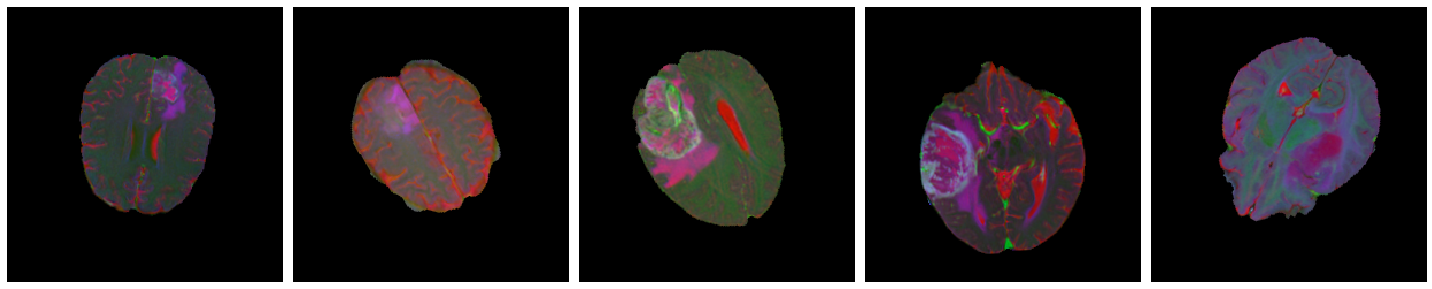

In [6]:
print(l[:5])
plots.plot_rgb_images(sample_training_images[:5])

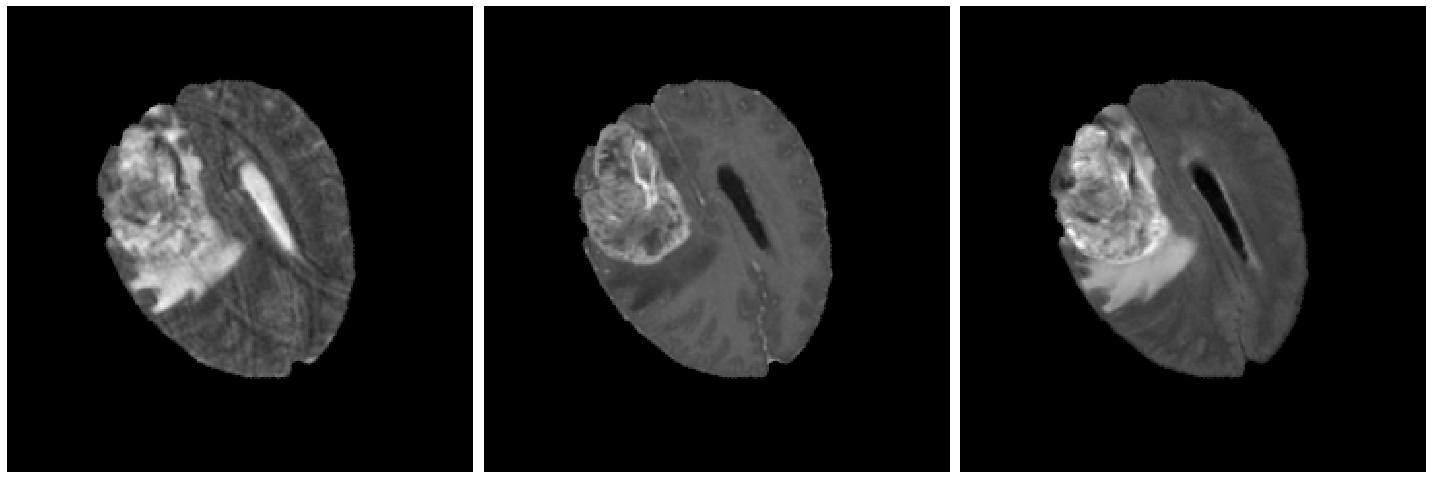

In [7]:
plots.plot_rgb_decomposition(sample_training_images[2])

#### Train model

In [8]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 120, 120, 16)      64        
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
__________

#### Evaluate model

In [10]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=1645 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=446 // batch_size
)

# Save the model
model.save(model_path);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
25/25 [==============================] - 17s 683ms/step - loss: 0.9364 - acc: 0.5371 - val_loss: 0.6949 - val_acc: 0.4583
Epoch 2/15
25/25 [==============================] - 16s 624ms/step - loss: 0.5830 - acc: 0.6844 - val_loss: 0.5783 - val_acc: 0.6414
Epoch 3/15
25/25 [==============================] - 16s 629ms/step - loss: 0.5025 - acc: 0.7367 - val_loss: 0.5059 - val_acc: 0.7251
Epoch 4/15
25/25 [==============================] - 15s 598ms/step - loss: 0.4627 - acc: 0.7467 - val_loss: 0.4493 - val_acc: 0.8351
Epoch 5/15
25/25 [==============================] - 16s 636ms/step - loss: 0.4856 - acc: 0.7469 - val_loss: 0.5027 - val_acc: 0.7670
Epoch 6/15
25/25 [==============================] - 15s 590ms/step - loss: 0.4443 - acc: 0.7787 - val_loss: 0.4657 - val_acc: 0.7225
Epoch 7/15
25/25 [==============================] - 16s 630ms/step - loss: 0.3962 - acc: 0.7967 - val_loss: 

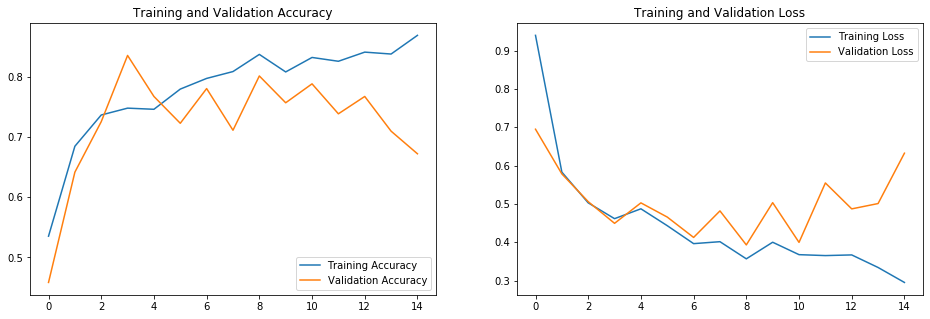

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Validation data 

Model performance:
              precision    recall  f1-score   support

         0.0       0.79      0.39      0.52       198
         1.0       0.65      0.92      0.76       248

    accuracy                           0.68       446
   macro avg       0.72      0.65      0.64       446
weighted avg       0.71      0.68      0.65       446



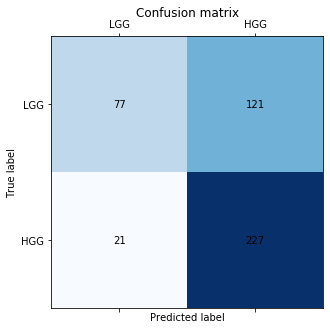

In [12]:
y_true = []
pred = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(val_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred.extend(p)
    y_true.extend(labels)
plots.plot_model_performance(y_true, pred)

##### Test data

Model performance:
              precision    recall  f1-score   support

         0.0       0.84      0.48      0.61       199
         1.0       0.68      0.92      0.78       239

    accuracy                           0.72       438
   macro avg       0.76      0.70      0.70       438
weighted avg       0.75      0.72      0.70       438



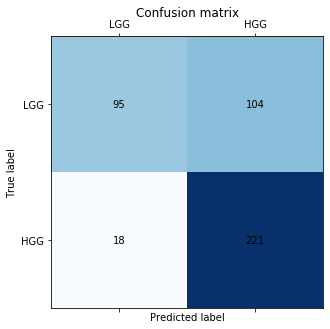

In [13]:
y_true = []
pred = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(test_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred.extend(p)
    y_true.extend(labels)
plots.plot_model_performance(y_true, pred)